# Stock Prediction using Stocker

Stocker ("stock explorer") is a Python-based toolkit for stock analysis and prediction. It is built on the quandl library for financial data, the prophet library from Facebook for additive models, numpy and pandas for data manipulation, and matplotlib for visualization. 

This notebook will document some of the basic capabilities of Stocker for prediction. First, I have to recommend against playing the stock market on a daily basis, with or without Stocker! Primarily I developed this tool to gain more experience with time series analysis and object-oriented programming. To see the code for Stocker, check out stocker.py and to see a notebook with analysis examples, look at the [Stocker Analysis Usage notebook](https://github.com/WillKoehrsen/Data-Analysis/blob/master/stocker/Stocker%20Analysis%20Usage.ipynb). 

In [3]:
# Matplotlib for plotting in the notebook
import matplotlib.pyplot as plt

%matplotlib inline

## Import the Stocker Class

In [2]:
from stocker import Stocker

### Instantiate a Stocker object 

We will be looking at Amazon stock data throughout this example. To retrieve the data, we pass the ticker to the stocker class and assign it to a variable. 

In [4]:
amazon = Stocker('AMZN')

AMZN Stocker Initialized. Data covers 1997-05-16 to 2018-03-27.


The Stocker object has a number of attributes and methods we can use for analysis and prediction. The main methods we will use in this notebook are `Stocker.create_prophet_model(), Stocker.changepoint_prior_analysis(), Stocker.changepoint_prior_validation(), Stocker.evaluate_prediction(),` and `Stocker.predict_future()`.

The most critical attributes for a forecast are `Stocker.changepoint_prior_scale, Stocker.training_years`, and the seasonalities included in the model. 

### Basic Plot of Stock History

We have a little over 20 years of Amazon price history. Let's see what that looks like in its entirety.

Maximum Adj. Close = 1598.39 on 2018-03-12.
Minimum Adj. Close = 1.40 on 1997-05-22.
Current Adj. Close = 1497.05 on 2018-03-27.



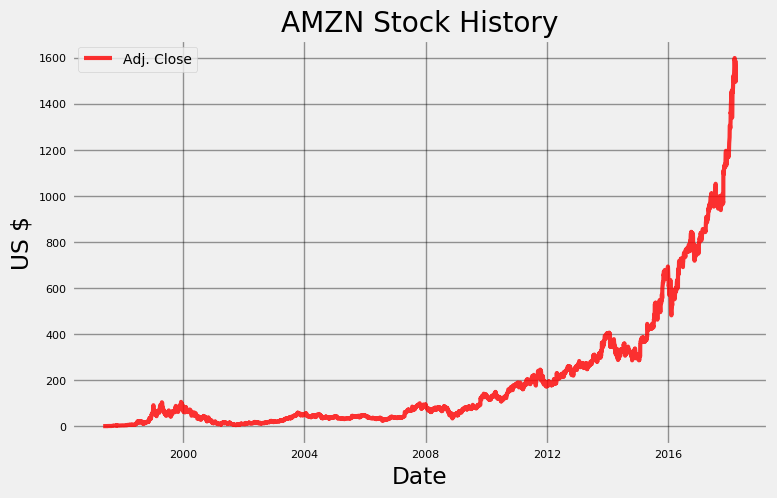

In [5]:
amazon.plot_stock()

Looks predictable right? 

### Plot of Daily Changes

Maximum Daily Change = 81.38 on 2018-02-06.
Minimum Daily Change = -79.20 on 2018-02-08.
Current Daily Change = -75.35 on 2018-03-27.



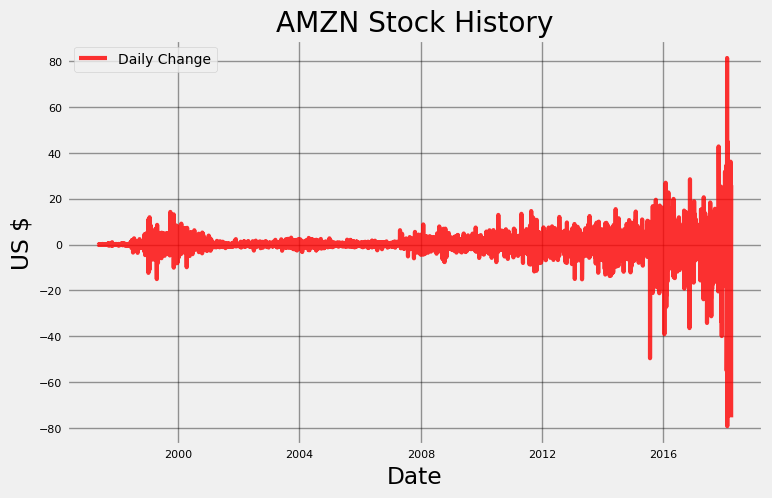

In [6]:
amazon.plot_stock(stats=['Daily Change'])

There have been some extreme changes in absolute magnitude recently, but these are not as large as they seem because the price of the stock has increased. We could change the plot to have percentage change on the y-axis. There do not appear to be trends with regards to the changes in one direction or the other. However, we know the stock has increased in value, so the overall average daily change must be slightly positive. 

## Examine Trends/Patterns

We can create a basic model (with no predictions) trained on the past 3 years of data to inspect any trends and patterns in the data. 

/opt/conda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


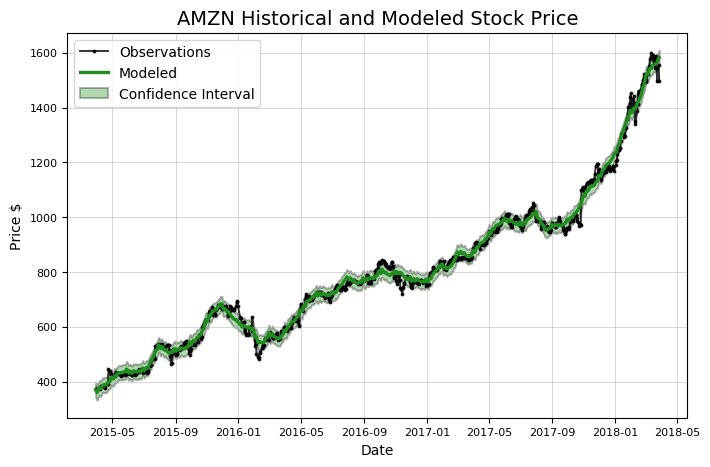

In [7]:
model, model_data = amazon.create_prophet_model()

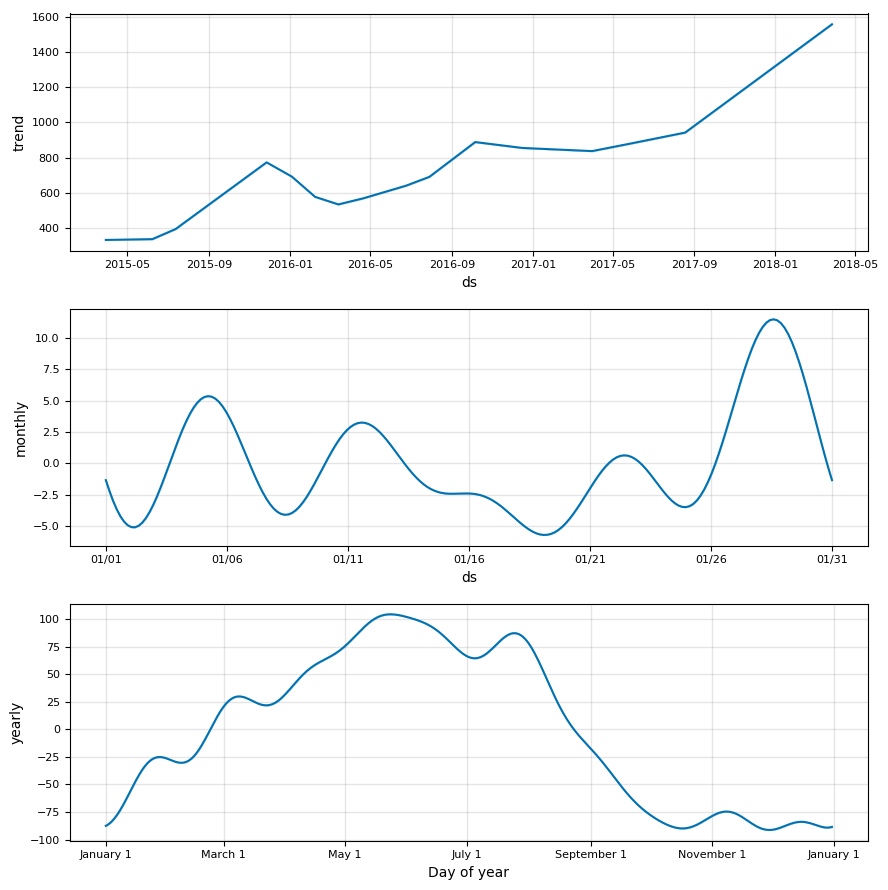

In [8]:
# Variables assigned from previous method call
model.plot_components(model_data)
plt.show()

### Test Addition of a Weekly Seasonality

Although it is unlikely, there might be a significant weekly component which would improve the model. Let's add it in and look at the pattern. 

/opt/conda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


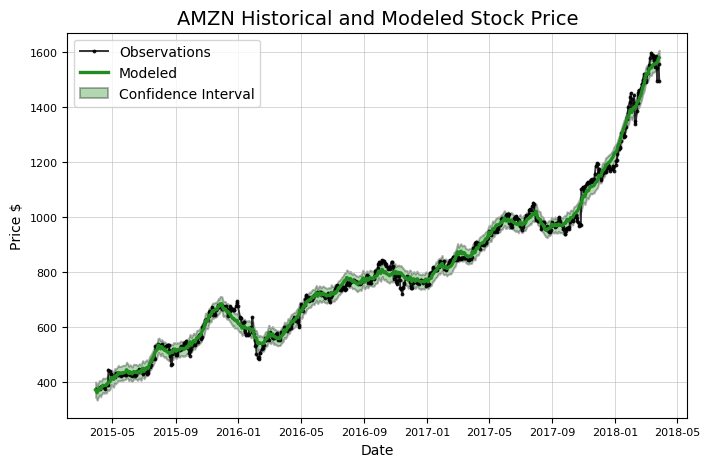

In [9]:
amazon.weekly_seasonality=True
model, model_data = amazon.create_prophet_model()

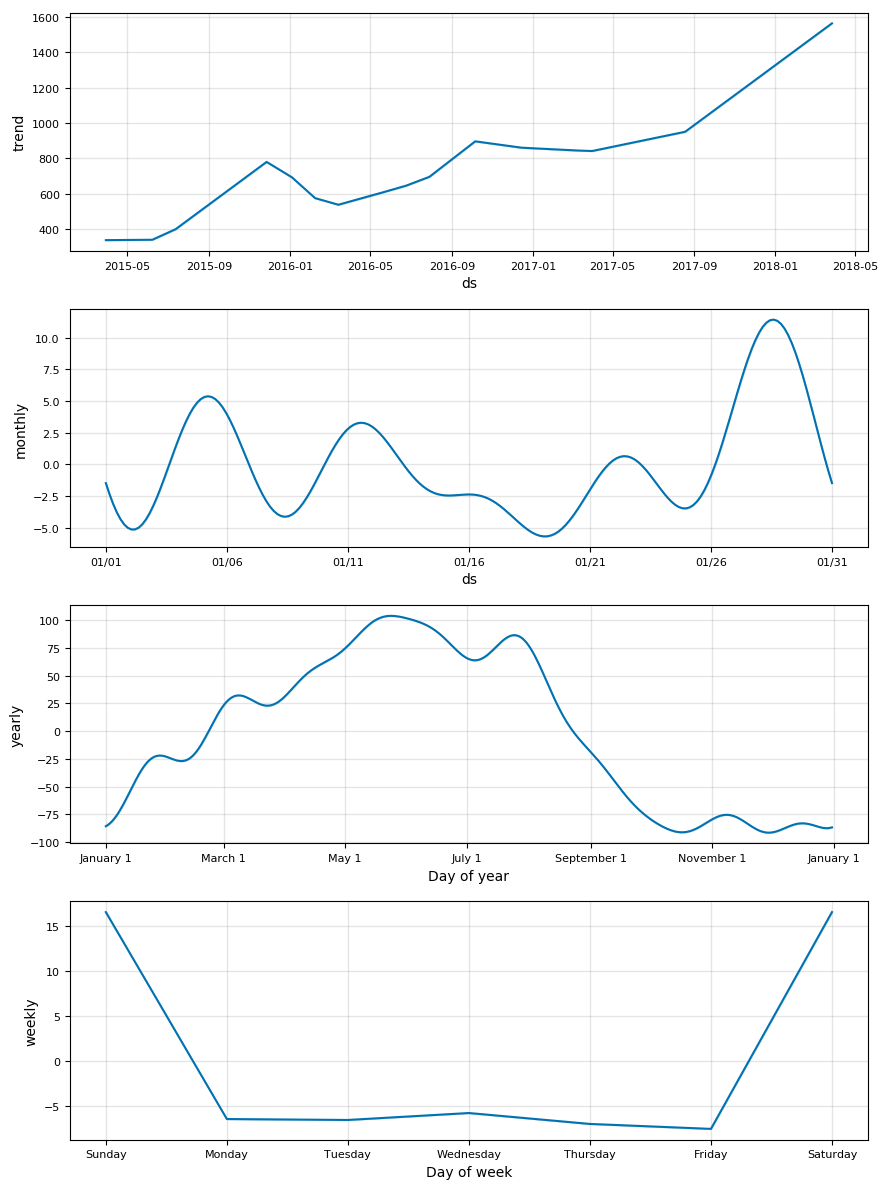

In [10]:
model.plot_components(model_data)
plt.show()

Maybe there is a slight weekly pattern? For now, we can remove that seasonality and then evaluate models with and without it to see the effect on predictions.

In [11]:
amazon.weekly_seasonality=False

# First Predictions

We can make a prediction for any number of specified days using the create model method. The prediction also includes the uncertainty interval, a necessity when making estimates about the future! 

/opt/conda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Predicted Price on 2018-06-25 = $1887.19


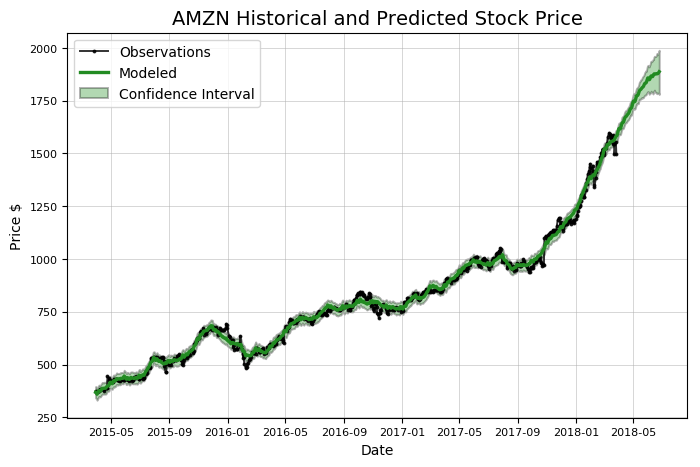

In [12]:
model, model_data = amazon.create_prophet_model(days=90)

The model predicts a continuous increase in price. Notice how the model for both the past data and the future data is smoother than the actual observations. The model smooths out the noise on the small scale in order to make more accurate general predictions over a long period. In other words, an additive model will be more accurate at capturing general movements rather than specific daily fluctuations. 

# Evaluate Model

Anyone can make stock predictions by simply picking a number. For our predictions to be meaningful, we must evaluate them on real data. 

One way to do this is set aside some historical data as a test set and use data from further back as our training set. In the default evaluation method, we test using the past year and train on the 3 years prior to the test period. 

To quantify the accuracy of our predictions, we can find the average dollar error on both the testing and training data, the percentage the actual price was in the predicted confidence interval, and the percentage of times we predicted the correct direction for the stock. 


Prediction Range: 2017-03-27 to 2018-03-27.

Predicted price on 2018-03-24 = $1056.88.
Actual price on    2018-03-23 = $1495.56.

Average Absolute Error on Training Data = $16.29.
Average Absolute Error on Testing  Data = $138.48.

When the model predicted an increase, the price increased 56.60% of the time.
When the model predicted a  decrease, the price decreased  40.45% of the time.

The actual value was within the 80% confidence interval 58.63% of the time.


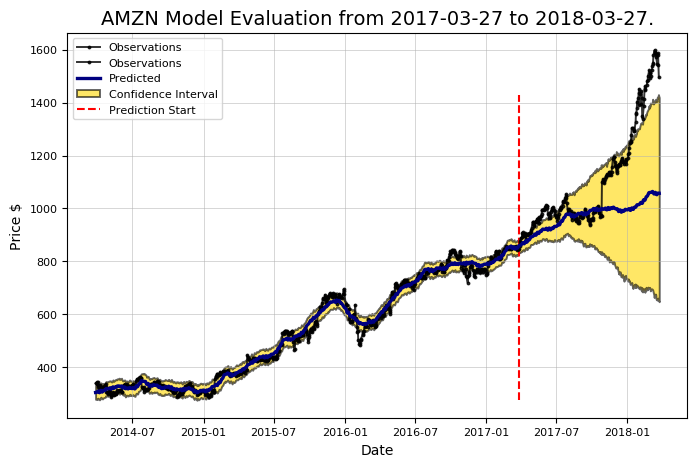

In [13]:
amazon.evaluate_prediction()

These predictions are not very good! However, it is likely that the model hyperparameters (settings) are not optimized for our problem. There are a number of these knobs we can adjust to improve the model, with perhaps the most important the changepoint prior scale, or the amount of weight the model assigns to shifts in the data.

# Changepoint Prior Scale Selection

Changepoints represent where a time series goes from increasing to decreasing or from increasing slowly to increasingly rapidly. They occur at the places with the [greatest change in the rate of the time series](https://facebook.github.io/prophet/docs/trend_changepoints.html). 

The changepoint prior scale represents the amount of weight given to the changepoints in the model. This can be used to control overfitting vs underfitting. A higher prior will create a model with more flexibility and more emphasis on the changepoints. This can lead to overfitting because the model will closely follow the training data. Lowering the prior decreases the model flexibility which can cause the opposite problem underfitting. This occurs when our model does not follow the training data closely enough and fails to learn the underlying relationships.

The Stocker class contains two different ways to choose an appropriate prior: grahically and quantitatively with validation data.

## Graphical Comparison

We will start with a range of four priors to compare. First, we can graphically compare them to get an intuition of how the priors affect the model.  

/opt/conda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


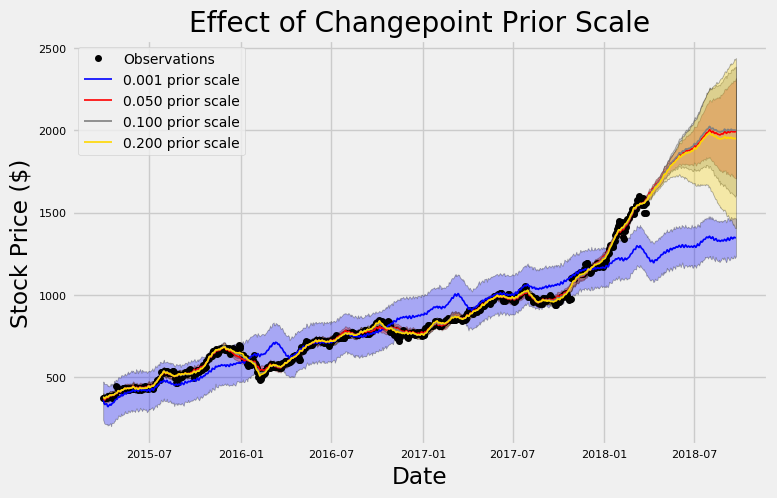

In [14]:
amazon.changepoint_prior_analysis(changepoint_priors=[0.001, 0.05, 0.1, 0.2])

## Quantitative Comparison

This gives us an idea of how well each prior fits the training data, but no numbers to back up our intuitions. The changepoint prior validation method is designed to provide numerical backing. We are testing from 2017-01-18 to 2018-01-18, so we need to make sure to use a different validation range. We will select two years prior to the testing date range. The model will be trained on the three years prior to the validation period.


Validation Range 2016-01-04 to 2017-01-03.



/opt/conda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


     cps  train_err  train_range    test_err  test_range
0  0.001  44.475809   152.582179  149.373638  152.873328
1  0.050  11.224915    35.889465  151.167979  133.137097
2  0.100  10.719979    34.609259  152.665794  173.665871
3  0.200   9.726249    31.943458  128.435804  326.944673


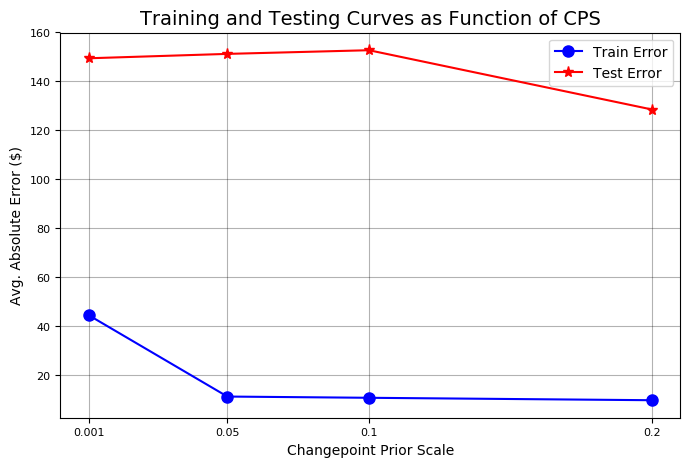

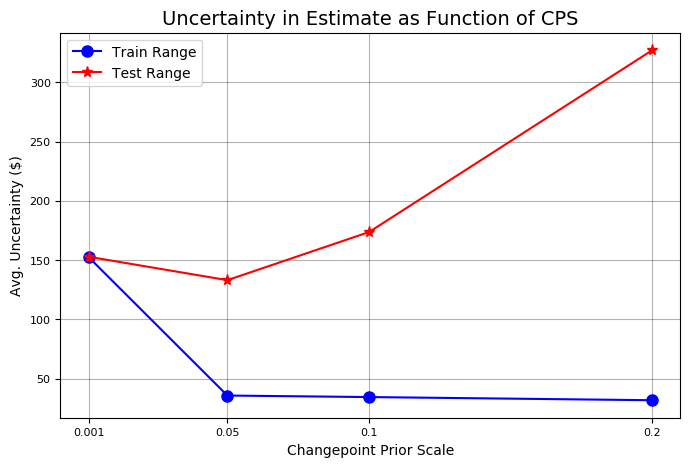

In [15]:
amazon.changepoint_prior_validation(start_date='2016-01-04', end_date='2017-01-03', changepoint_priors=[0.001, 0.05, 0.1, 0.2])

The test error decreases as we increase the prior. Stocks change considerably on a day to day basis, and a more flexible model can account for these fluctuations.

### Refine Search 

We can evaluate additional changepoint prior scales to determine the best fit for our data. 


Validation Range 2016-01-04 to 2017-01-03.



/opt/conda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


    cps  train_err  train_range    test_err  test_range
0  0.15  10.290060    33.385833  145.720236  228.006227
1  0.20   9.726249    31.935967  128.435804  321.374242
2  0.25   9.203938    30.540537  114.643675  465.790455
3  0.40   8.572920    28.908723   82.862352  752.995782
4  0.50   8.391545    28.430686   70.133190  826.075658
5  0.60   8.274461    28.076050   67.236863  946.749836


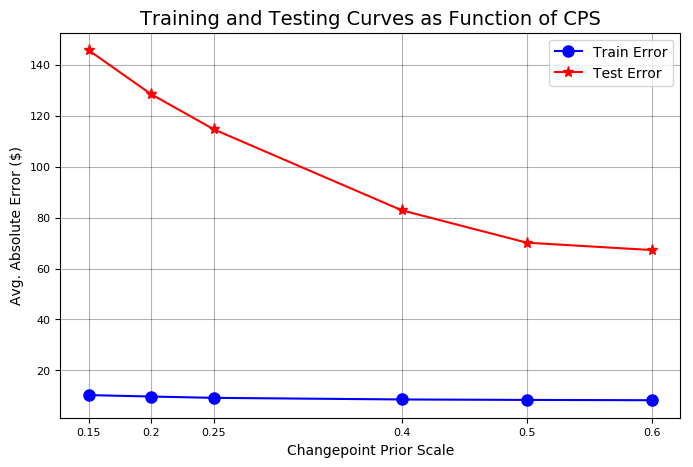

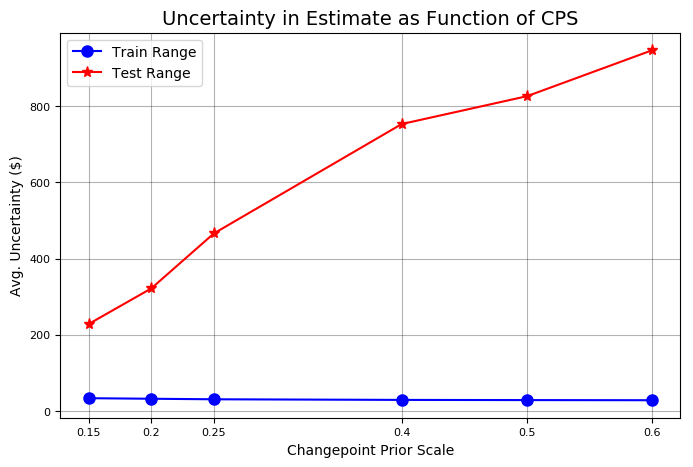

In [16]:
amazon.changepoint_prior_validation(start_date='2016-01-04', end_date='2017-01-03', changepoint_priors=[0.15, 0.2, 0.25,0.4, 0.5, 0.6])

We now assign the changepoint prior with the smallest error on the testing set to the Stocker object. The prior is one of the attiributes and we can change it like any other variable. At this point, we could also change the seasonalities or the amount of training data to achieve the best performance on the testing data

In [17]:
amazon.changepoint_prior_scale = 0.5

### Evaluate Improved Model

/opt/conda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):



Prediction Range: 2017-03-27 to 2018-03-27.

Predicted price on 2018-03-24 = $994.94.
Actual price on    2018-03-23 = $1495.56.

Average Absolute Error on Training Data = $10.75.
Average Absolute Error on Testing  Data = $181.38.

When the model predicted an increase, the price increased 59.33% of the time.
When the model predicted a  decrease, the price decreased  44.90% of the time.

The actual value was within the 80% confidence interval 83.53% of the time.


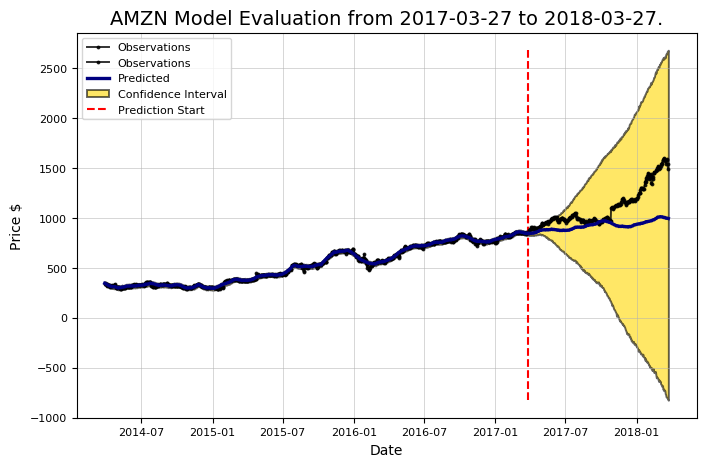

In [18]:
amazon.evaluate_prediction()

#### Add in weekly seasonality and evaluate

In [19]:
amazon.weekly_seasonality=True

/opt/conda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):



Prediction Range: 2017-03-27 to 2018-03-27.

Predicted price on 2018-03-24 = $977.40.
Actual price on    2018-03-23 = $1495.56.

Average Absolute Error on Training Data = $10.74.
Average Absolute Error on Testing  Data = $175.53.

When the model predicted an increase, the price increased 61.59% of the time.
When the model predicted a  decrease, the price decreased  48.45% of the time.

The actual value was within the 80% confidence interval 85.94% of the time.


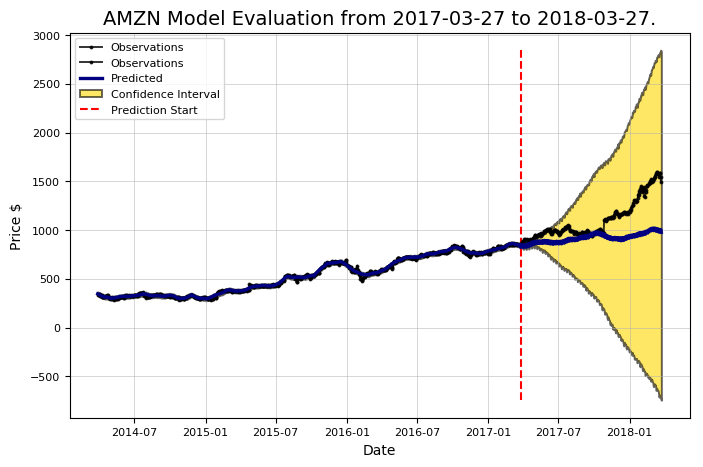

In [20]:
amazon.evaluate_prediction()

The best changepoint prior scale for our model is 0.5 and including the weekly seasonality did not improve the model. Therefore, we will change these settings accordingly. 

In [21]:
amazon.changepoint_prior_scale=0.5
amazon.weekly_seasonality=True

## Play the Daily Market

For fun (this should never be done for real) we can "play" the market with our predictions. We will compare our model with the simple strategy of buying and holding over the same time period. The rules of our game are straightforward:

1. If we predict the price will increase, we buy stock on that day. If we predict a decrease, we do not play the market.
2. If we predicted an increase and the stock does increase, we recieve the change in price of the stock over that day times the number of shares.
3. If we predicted an increase and the stock decreases, we lose the change in price of the stock over that day times the number of shares.

We are assuming the "change in price of a share on that day" is the difference between the previous days' closing price and the closing price on our day. For example, if the closing price on Monday was \$14 and the closing price on Tuesday was \$18, we would call that a \$4 change on Tuesday. This is not entirely accurate as stocks prices change a small amount overnight, but it will be acceptable for our game. Now, let's play with the defaults.

/opt/conda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/jovyan/work/stocker.py:613: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  test_pred_increase['pred_profit'] = prediction_profit


You played the stock market in AMZN from 2017-03-27 to 2018-03-27 with 1000 shares.

When the model predicted an increase, the price increased 61.59% of the time.
When the model predicted a  decrease, the price decreased  48.45% of the time.

The total profit using the Prophet model = $579090.00.
The Buy and Hold strategy profit =         $648740.00.

Thanks for playing the stock market!



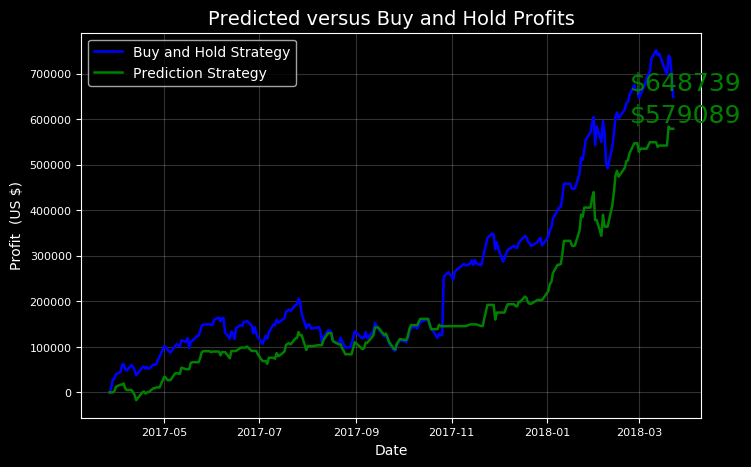

In [22]:
amazon.evaluate_prediction(nshares=1000)

Notice that our profits do not depend on the difference between the final predicted price and the actual price, only on the percentage of the time we correctly predicted the direction. We could alter the rules of the game to play it based on predicted values, but for now we can leave it at the rather simple exercise shown here. 

#### Try a Different Period

We can evaluate any time period we like to see if there are times when we beat the buy and hold strategy. More likely is that we will find times when we lose money. Nonetheless, it is important to test over different time frames to see how robust the model is to training data.

You played the stock market in AMZN from 2008-01-03 to 2009-01-05 with 1000 shares.

When the model predicted an increase, the price increased 43.27% of the time.
When the model predicted a  decrease, the price decreased  55.00% of the time.

The total profit using the Prophet model = $-38260.00.
The Buy and Hold strategy profit =         $-43930.00.

Thanks for playing the stock market!



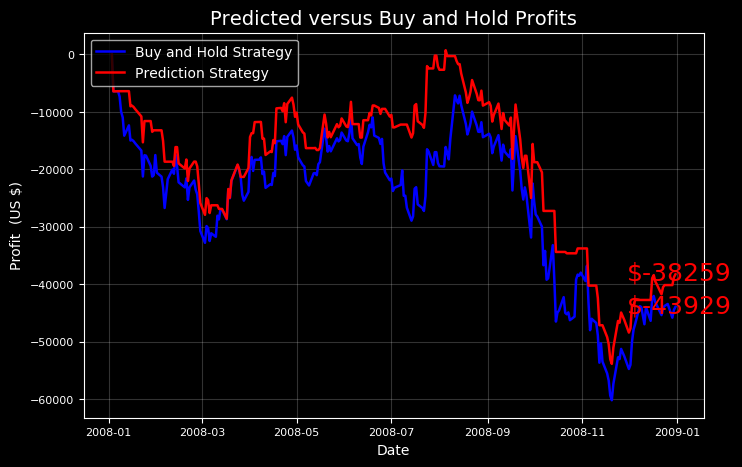

In [22]:
amazon.evaluate_prediction(start_date = '2008-01-03', end_date = '2009-01-05', nshares=1000)

# Predict the Future

As a last step, we can predict any number of days into the future. This function automatically trains on the past 3 years and makes predictions with the uncertainty intervals. 

/opt/conda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):



Predicted Increase: 

         Date     estimate     change        upper        lower
1  2018-03-28  1573.730950   2.298022  1595.554170  1553.042421
2  2018-03-29  1575.833058   2.102108  1595.917786  1553.862396
3  2018-03-30  1582.301164   6.468106  1602.388287  1559.404065
5  2018-04-01  1625.451422  43.150257  1648.357064  1604.193542
8  2018-04-04  1597.412067   0.330480  1617.598903  1575.525568
9  2018-04-05  1599.437610   2.025543  1622.347957  1576.014490
10 2018-04-06  1606.074336   6.636726  1628.426477  1583.103988

Predicted Decrease: 

        Date     estimate     change        upper        lower
6 2018-04-02  1597.866066 -27.585356  1619.622713  1576.580801
7 2018-04-03  1597.081588  -0.784478  1617.582559  1576.846385


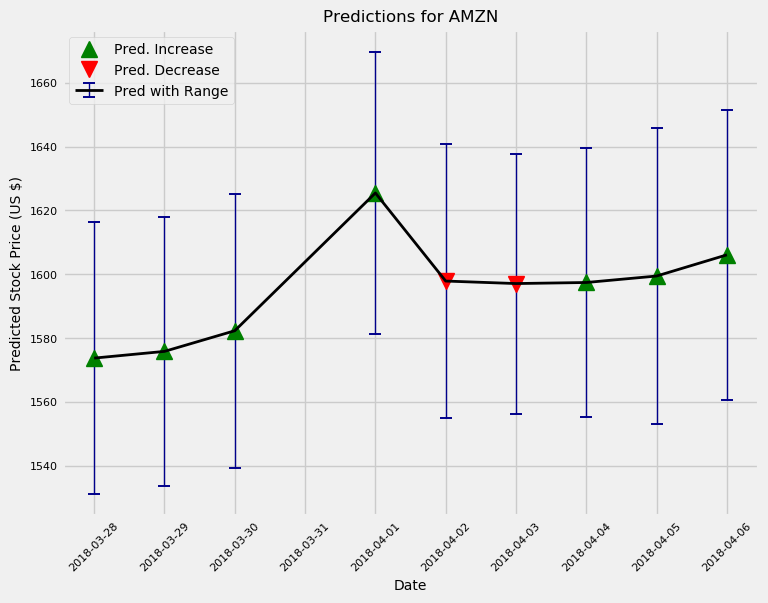

In [23]:
amazon.predict_future(days=10)


Predicted Increase: 

          Date     estimate     change        upper        lower
1   2018-01-23  1306.228442   6.025072  1326.161058  1288.043281
2   2018-01-24  1311.564033   5.335591  1331.453768  1291.165245
3   2018-01-25  1314.109191   2.545158  1332.027122  1293.957448
4   2018-01-26  1315.050236   0.941045  1335.034202  1293.421066
6   2018-01-28  1327.643659  12.593423  1348.690399  1307.735908
7   2018-01-29  1329.362177   1.718518  1348.764027  1308.724903
8   2018-01-30  1334.349879   4.987701  1354.423431  1316.151848
9   2018-01-31  1336.068697   1.718819  1357.488546  1316.962015
13  2018-02-04  1344.427783  11.606116  1367.526264  1322.719958
14  2018-02-05  1345.053218   0.625434  1368.103802  1322.951085
15  2018-02-06  1348.389628   3.336410  1371.113281  1326.592277
16  2018-02-07  1349.548072   1.158444  1374.324334  1327.575564
17  2018-02-08  1349.692806   0.144734  1373.166019  1327.535413
18  2018-02-09  1351.331035   1.638229  1376.361037  1329.155187
20

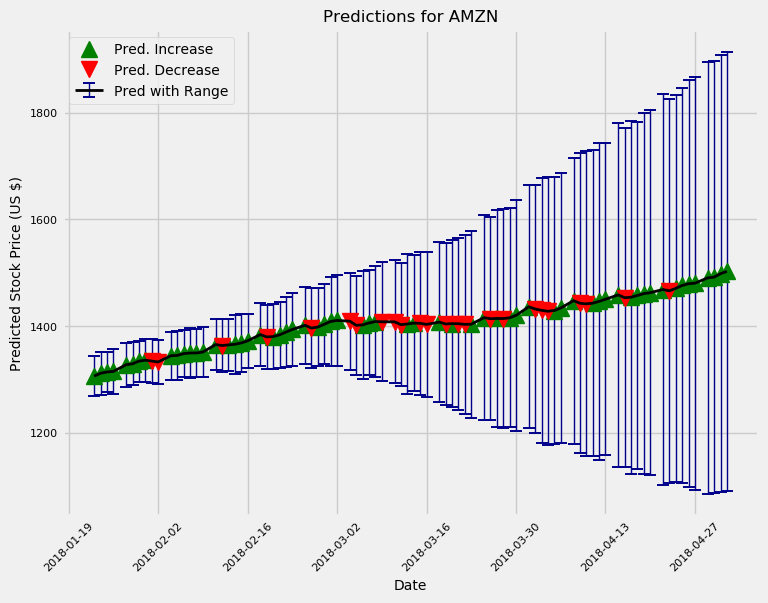

In [24]:
amazon.predict_future(days=100)

The uncertainty increases the farther out in the future we predict. This is to be expected because the initial forecasted values have some uncertainty, and the next values are made based on the previous ones, so the range of possible values grows over time. 

Whenever we make a prediction, we must be sure to include uncertainty intervals because there are no processes that can be exactly estimated in the future. While most people interpret a confidence interval as a lack of confidence, it really displays that we know the limitations of our model. 